<a href="https://colab.research.google.com/github/jackkim-usd/AAI521-group4/blob/ahmed/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)

In [2]:
# Load dataset + metadata
(ds_all, ds_info) = tfds.load(
    "plant_village",
    split="train",
    as_supervised=True,
    with_info=True
)

total = ds_info.splits["train"].num_examples
print("Total images:", total)

# Shuffle with fixed seed
ds_all = ds_all.shuffle(10000, seed=4, reshuffle_each_iteration=False)

# Subset sizes
train_count = 10000
val_count   = 2000
test_count  = 2000

train_ds = ds_all.take(train_count)
rest_ds  = ds_all.skip(train_count)
val_ds   = rest_ds.take(val_count)
test_ds  = rest_ds.skip(val_count).take(test_count)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.1MKJQZ_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Total images: 54303


In [3]:
# Data augmentation layers
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, img_size, batch_size, training):
    def _resize_normalize(image, label):
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.cast(image, tf.float32)
        return image, label

    ds = ds.map(_resize_normalize, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(1000)
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [4]:
IMG_SIZE = 299
BATCH_SIZE = 32
NUM_CLASSES = ds_info.features["label"].num_classes

train = prepare_dataset(train_ds, IMG_SIZE, BATCH_SIZE, training=True)
val   = prepare_dataset(val_ds, IMG_SIZE, BATCH_SIZE, training=False)
test  = prepare_dataset(test_ds, IMG_SIZE, BATCH_SIZE, training=False)


In [5]:
base = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False  # Freeze base layers first

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        77,862 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,880,646 (83.47 MB)

 Trainable params: 77,862 (304.15 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [6]:
history = model.fit(
    train,
    validation_data=val,
    epochs=10
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 268ms/step - accuracy: 0.1658 - loss: 3.2290 - val_accuracy: 0.4840 - val_loss: 2.2055
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 214ms/step - accuracy: 0.4799 - loss: 2.0939 - val_accuracy: 0.6525 - val_loss: 1.6088
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 213ms/step - accuracy: 0.6211 - loss: 1.5885 - val_accuracy: 0.7275 - val_loss: 1.2835
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 211ms/step - accuracy: 0.6987 - loss: 1.2976 - val_accuracy: 0.7670 - val_loss: 1.0764
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 212ms/step - accuracy: 0.7495 - loss: 1.0951 - val_accuracy: 0.7975 - val_loss: 0.9458
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 211ms/step - accuracy: 0.7762 - loss: 0.9596 - val_accuracy: 0.8095 - val_loss: 0.8469
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 211ms/step - accuracy: 0.8011 - loss: 0.8539 - val_accuracy: 0.8260 - val_loss: 0.7715
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 211ms/step - accuracy: 0.8133 - loss: 

In [7]:
base.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train,
    validation_data=val,
    epochs=5
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 276s 637ms/step - accuracy: 0.5873 - loss: 1.5821 - val_accuracy: 0.8915 - val_loss: 0.4178
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 157s 497ms/step - accuracy: 0.8939 - loss: 0.4166 - val_accuracy: 0.9300 - val_loss: 0.2476
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 501ms/step - accuracy: 0.9310 - loss: 0.2613 - val_accuracy: 0.9475 - val_loss: 0.1831
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 501ms/step - accuracy: 0.9542 - loss: 0.1793 - val_accuracy: 0.9600 - val_loss: 0.1402
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 502ms/step - accuracy: 0.9657 - loss: 0.1363 - val_accuracy: 0.9635 - val_loss: 0.1184


In [8]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

print("Test Accuracy:", acc)
print("Macro F1 Score:", f1_macro)
print("Weighted F1 Score:", f1_weighted)


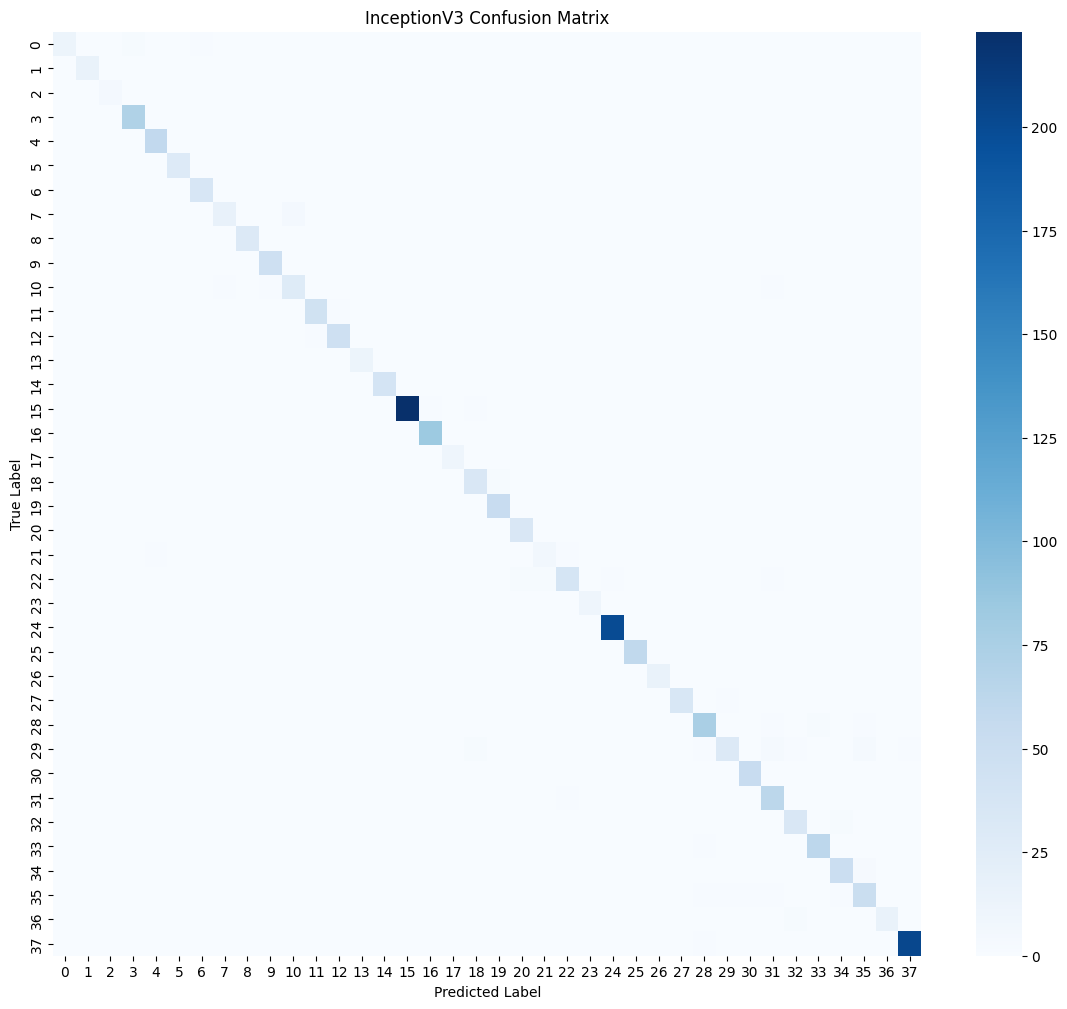

In [10]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [11]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00         5
           3       0.97      1.00      0.99        71
           4       0.98      1.00      0.99        59
           5       1.00      1.00      1.00        29
           6       0.97      1.00      0.99        36
           7       0.94      0.77      0.85        22
           8       1.00      1.00      1.00        31
           9       0.98      1.00      0.99        47
          10       0.85      0.90      0.88        31
          11       0.98      0.98      0.98        45
          12       0.98      0.98      0.98        48
          13       1.00      1.00      1.00        13
          14       1.00      1.00      1.00        40
          15       1.00      0.99      1.00       225
          16       0.99      1.00      0.99        84
          17       1.00    